### Importando os Pacotes Utilitários

In [1]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import Sequence 
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import shutil
import random

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

### Baixando os Dados do Servidor

In [3]:
shutil.unpack_archive(filename = '/content/drive/MyDrive/datasets-lung-loc/CheXpert-v1.0-small.zip', 
                      extract_dir = '/content/CheXpert-v1.0-small', format = 'zip')

In [4]:
shutil.unpack_archive(filename = '/content/drive/MyDrive/datasets-lung-loc/vinbigdata.zip', 
                      extract_dir = '/content/vinbigdata/', format = 'zip')

In [5]:
shutil.unpack_archive(filename = '/content/drive/MyDrive/datasets-lung-loc/images.zip', 
                      extract_dir = '/content/images/', format = 'zip')

### Organizando e Analisando os Dados

In [6]:
dataset = pd.read_csv('/content/all_datasets.csv', index_col = 0)
dataset_diseases = dataset[((dataset['Opacity'] == 1.0) | 
                            (dataset['Atelectasis'] == 1.0) | 
                            (dataset['Pneumothorax'] == 1.0) | 
                            (dataset['Effusion'] == 1.0)) & 
                            (dataset['Nodule/Mass'] == 0.0) &
                            (dataset['No Finding'] == 0.0)].copy()

dataset_diseases.drop(labels = 'Nodule/Mass', axis = 1, inplace = True)
dataset_diseases.drop(labels = 'No Finding', axis = 1, inplace = True)
labels = ['Opacity', 'Atelectasis', 'Pneumothorax', 'Effusion']

dataset_no_diseases = dataset[dataset['No Finding'] == 1.0].copy()

dataset_diseases['Abnormal'] = 1.0
dataset_no_diseases['Abnormal'] = 0.0

dataset = pd.concat((dataset_diseases, dataset_no_diseases))

In [7]:
findings = ['Opacity', 'Atelectasis', 'Pneumothorax', 'Effusion', 'No Finding']
findings_pt = ['Opacidade', 'Atelectasia', 'Pneumotórax', 'Efusão', 'Normal']

Text(0, 0.5, 'Imagens')

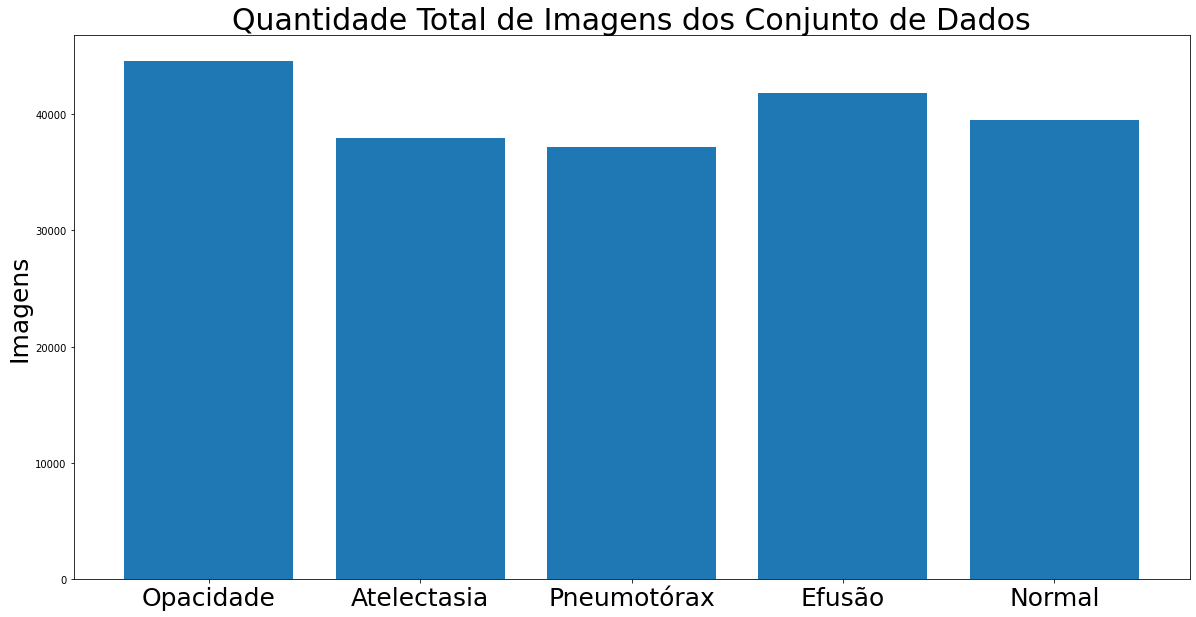

In [8]:
count_findings = list()
for finding in findings:
  count = dict(dataset[finding].value_counts())[1.0]
  count_findings.append(count)

plt.figure(figsize = (20, 10))
plt.bar(findings_pt, count_findings)
plt.xticks(rotation = 0, size = 25)
plt.title('Quantidade Total de Imagens dos Conjunto de Dados', size = 30)
plt.ylabel('Imagens', size = 25)

In [9]:
opacity = np.array(dataset_diseases['Opacity']).astype(str)
atelectasis = np.array(dataset_diseases['Atelectasis']).astype(str)
pneumothorax = np.array(dataset_diseases['Pneumothorax']).astype(str)
effusion = np.array(dataset_diseases['Effusion']).astype(str)

all_labels = np.zeros(effusion.shape).astype(str)
for index in range(0, len(opacity)):
  all_labels[index] = opacity[index] + atelectasis[index] + pneumothorax[index]
  all_labels[index] += effusion[index]

dataset_diseases['labels_ref'] = all_labels

In [10]:
_, dataset_diseases = train_test_split(dataset_diseases, test_size = 0.45011, 
                                       random_state = 42, 
                                       stratify = dataset_diseases['labels_ref'])

dataset = pd.concat((dataset_diseases, dataset_no_diseases))

Text(0, 0.5, 'Imagens')

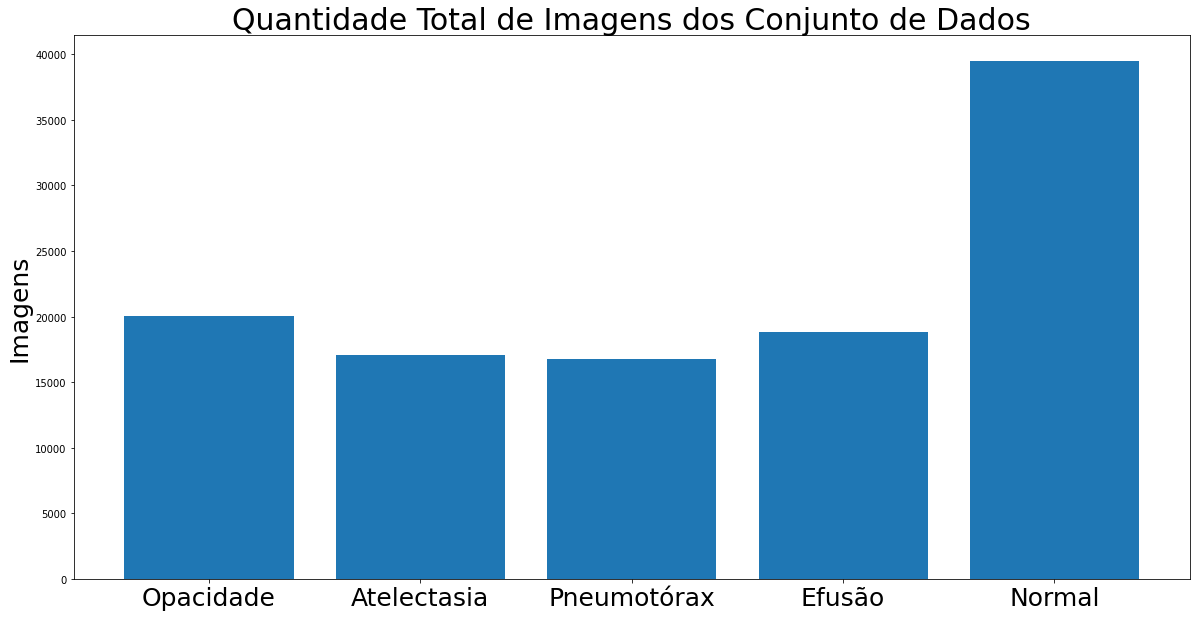

In [11]:
count_findings = list()
for finding in findings:
  count = dict(dataset[finding].value_counts())[1.0]
  count_findings.append(count)

plt.figure(figsize = (20, 10))
plt.bar(findings_pt, count_findings)
plt.xticks(rotation = 0, size = 25)
plt.title('Quantidade Total de Imagens dos Conjunto de Dados', size = 30)
plt.ylabel('Imagens', size = 25)

Text(0, 0.5, 'Imagens')

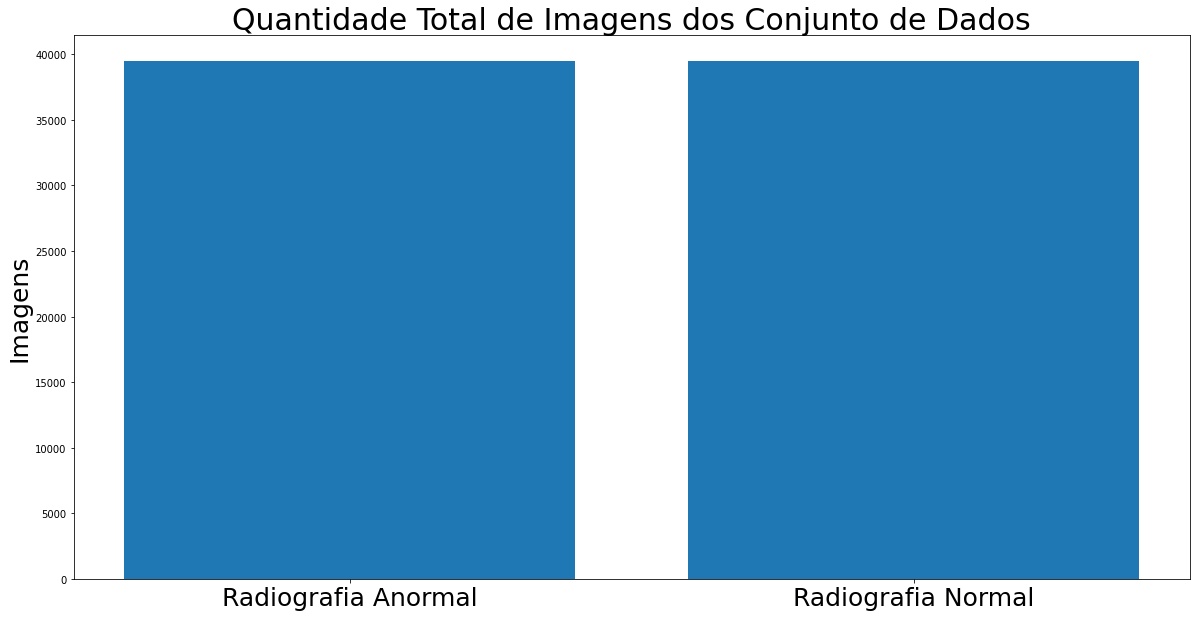

In [12]:
count_findings = list()
count_findings.append(dict(dataset['Abnormal'].value_counts())[1.0])
count_findings.append(dict(dataset['Abnormal'].value_counts())[0.0])

plt.figure(figsize = (20, 10))
plt.bar(['Radiografia Anormal', 'Radiografia Normal'], count_findings)
plt.xticks(rotation = 0, size = 25)
plt.title('Quantidade Total de Imagens dos Conjunto de Dados', size = 30)
plt.ylabel('Imagens', size = 25)

In [13]:
f_train, f_val = train_test_split(dataset, test_size = 0.2, random_state = 42, 
                                  stratify = dataset['Abnormal'])
f_val, f_test = train_test_split(f_val, test_size = 0.5, random_state = 42, 
                                 stratify = f_val['Abnormal'])

f_train.drop(labels = ['labels_ref'], axis = 1, inplace = True)
f_val.drop(labels = ['labels_ref'], axis = 1, inplace = True)
f_test.drop(labels = ['labels_ref'], axis = 1, inplace = True)

Text(0, 0.5, 'Imagens')

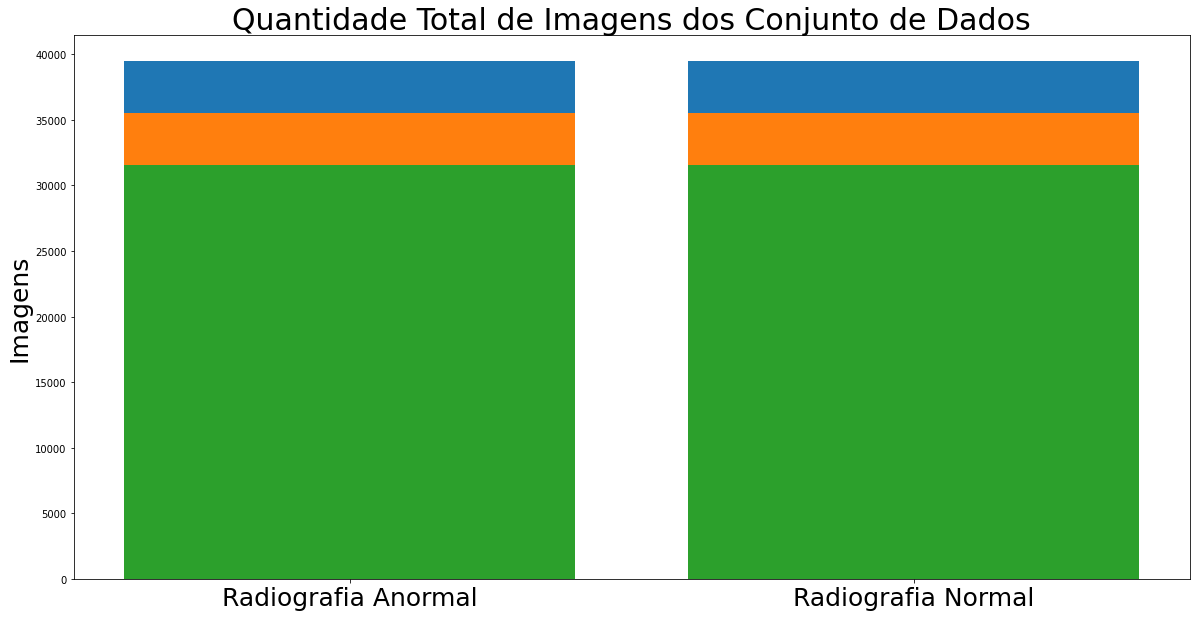

In [14]:
count_train, count_val, count_test = [], [], []
count_train.append(dict(f_train['Abnormal'].value_counts())[1.0])
count_train.append(dict(f_train['Abnormal'].value_counts())[0.0])
count_val.append(dict(f_val['Abnormal'].value_counts())[1.0])
count_val.append(dict(f_val['Abnormal'].value_counts())[0.0])
count_test.append(dict(f_test['Abnormal'].value_counts())[1.0])
count_test.append(dict(f_test['Abnormal'].value_counts())[0.0])

plt.figure(figsize = (20, 10))
plt.bar(['Radiografia Anormal', 'Radiografia Normal'], 
        np.sum((count_train, count_val, count_test), axis = 0))
plt.bar(['Radiografia Anormal', 'Radiografia Normal'], 
        np.sum((count_train, count_val), axis = 0))
plt.bar(['Radiografia Anormal', 'Radiografia Normal'], count_train)

plt.xticks(rotation = 0, size = 25)
plt.title('Quantidade Total de Imagens dos Conjunto de Dados', size = 30)
plt.ylabel('Imagens', size = 25)

### Gerador de Imagens do Keras

In [15]:
f_train_normal = f_train[f_train['Abnormal'] == 0.0]
f_val_normal = f_val[f_val['Abnormal'] == 0.0]
f_test_normal = f_test[f_test['Abnormal'] == 0.0]

f_train_abnormal = f_train[f_train['Abnormal'] == 1.0]
f_val_abnormal = f_val[f_val['Abnormal'] == 1.0]
f_test_abnormal = f_test[f_test['Abnormal'] == 1.0]

In [16]:
image_size, batch_size = 120, 500
labels = ['Abnormal']

In [17]:
core_idg_train = ImageDataGenerator(rescale = 1/255., rotation_range = 3, 
                                    width_shift_range = 0.05, 
                                    height_shift_range = 0.05, 
                                    fill_mode = 'constant')
core_idg_test = ImageDataGenerator(rescale = 1/255.)

In [18]:
train_gen_normal = core_idg_train.flow_from_dataframe(dataframe = f_train_normal, directory = None, 
                                                      x_col = 'Path', y_col = labels, 
                                                      class_mode = 'input', 
                                                      batch_size = batch_size,
                                                      target_size = (image_size, image_size), 
                                                      color_mode = 'grayscale', shuffle = True)

valid_gen_normal = core_idg_test.flow_from_dataframe(dataframe = f_val_normal, directory = None, 
                                                     x_col = 'Path',  y_col = labels, 
                                                     class_mode = 'input', 
                                                     batch_size = batch_size,
                                                     target_size = (image_size, image_size),
                                                     color_mode = 'grayscale', shuffle = True)

test_gen_normal = core_idg_test.flow_from_dataframe(dataframe = f_test_normal, directory = None, 
                                                    x_col = 'Path', y_col = labels, 
                                                    class_mode = 'input', batch_size = batch_size,
                                                    target_size = (image_size, image_size),
                                                    color_mode = 'grayscale', shuffle = False)

Found 31580 validated image filenames.
Found 3947 validated image filenames.
Found 3948 validated image filenames.


In [19]:
train_gen_abnormal = core_idg_train.flow_from_dataframe(dataframe = f_train_abnormal, directory = None, 
                                                        x_col = 'Path', y_col = labels, 
                                                        class_mode = 'input', 
                                                        batch_size = batch_size,
                                                        target_size = (image_size, image_size), 
                                                        color_mode = 'grayscale', shuffle = True)

valid_gen_abnormal = core_idg_test.flow_from_dataframe(dataframe = f_val_abnormal, directory = None, 
                                                       x_col = 'Path',  y_col = labels, 
                                                       class_mode = 'input', 
                                                       batch_size = batch_size,
                                                       target_size = (image_size, image_size),
                                                       color_mode = 'grayscale', shuffle = True)

test_gen_abnormal = core_idg_test.flow_from_dataframe(dataframe = f_test_abnormal, directory = None, 
                                                      x_col = 'Path', y_col = labels, 
                                                      class_mode = 'input', batch_size = batch_size,
                                                      target_size = (image_size, image_size),
                                                      color_mode = 'grayscale', shuffle = False)

Found 31580 validated image filenames.
Found 3948 validated image filenames.
Found 3947 validated image filenames.


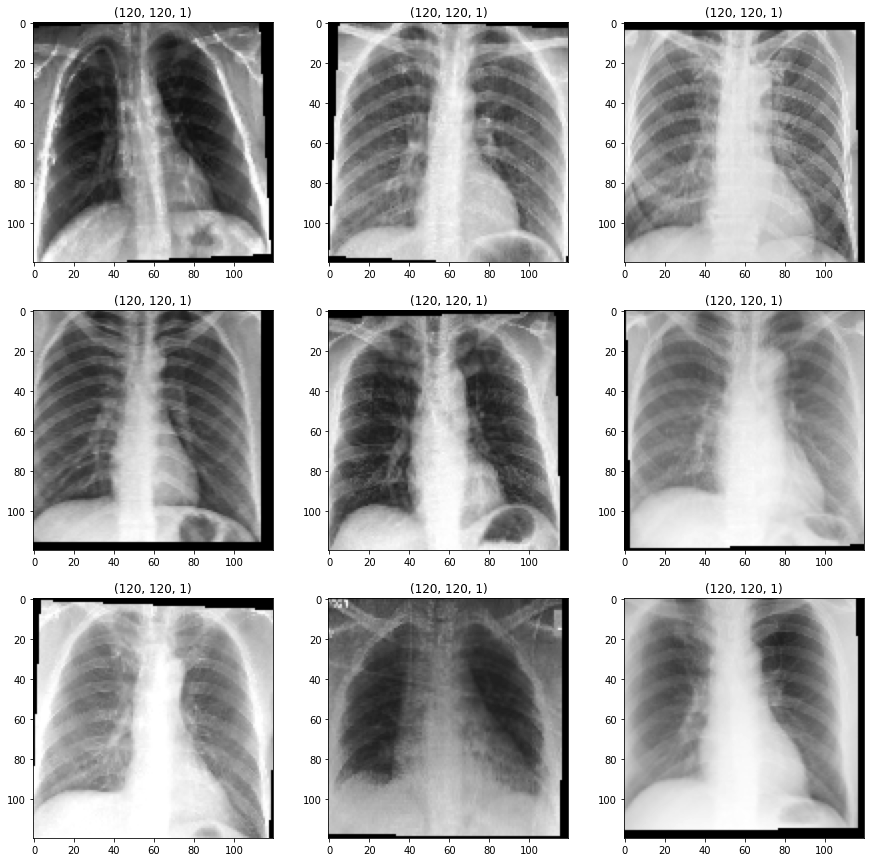

In [20]:
(x,y) = train_gen_normal[0]
fig, axs = plt.subplots(3, 3, figsize = (15, 15))
count = 0
for i in range(0,3):
  for j in range(0,3):
    axs[i,j].imshow(x[count][:, :, 0], cmap = 'gray')
    axs[i,j].set_title(f'{x[0].shape}')
    count +=1

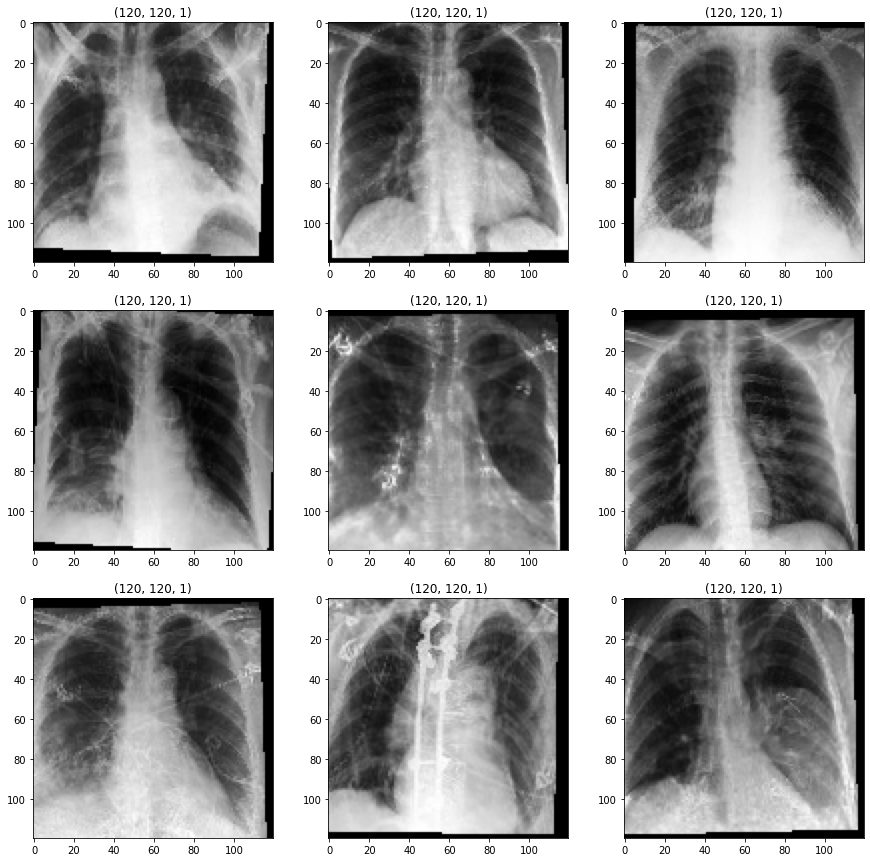

In [21]:
(x,y) = train_gen_abnormal[1]
fig, axs = plt.subplots(3, 3, figsize = (15, 15))
count = 0
for i in range(0,3):
  for j in range(0,3):
    axs[i,j].imshow(x[count][:, :, 0], cmap = 'gray')
    axs[i,j].set_title(f'{x[0].shape}')
    count +=1

### Basic Autoencoder

In [ ]:
input = tf.keras.layers.Input(shape = (120, 120, 1))

x = tf.keras.layers.Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu', 
                           padding = 'same', strides = 2)(input)
x = tf.keras.layers.Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu', 
                           padding = 'same', strides = 2)(x)
x = tf.keras.layers.Conv2D(filters = 16, kernel_size = (3,3), activation = 'relu', 
                           padding = 'same', strides = 2)(x)

x = tf.keras.layers.Conv2DTranspose(filters = 16, kernel_size = 3, strides = 2,
                                    activation = 'relu', padding = 'same')(x)
x = tf.keras.layers.Conv2DTranspose(filters = 32, kernel_size = 3, strides = 2,
                                    activation = 'relu', padding = 'same')(x)  
x = tf.keras.layers.Conv2DTranspose(filters = 64, kernel_size = 3, strides = 2,
                                    activation = 'relu', padding = 'same')(x) 

output = tf.keras.layers.Conv2D(filters = 1, kernel_size = (3, 3), activation = 'sigmoid', 
                                padding = 'same')(x)   

model = tf.keras.models.Model(inputs = input, outputs = output)
model.compile(optimizer = 'adam', loss = tf.keras.losses.MeanSquaredError())

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 120, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 60, 60, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 32)        18464     
                                                                 
 conv2d_2 (Conv2D)           (None, 15, 15, 16)        4624      
                                                                 
 conv2d_transpose (Conv2DTra  (None, 30, 30, 16)       2320      
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 60, 60, 32)       4640      
 ranspose)                                                   

In [22]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath = 'weights.hdf5', monitor = 'loss', 
                                                verbose = True, save_best_only = True, 
                                                save_weights_only = True)

callbacks = [checkpoint]

In [ ]:
model.fit(train_gen_normal, validation_data = valid_gen_normal, epochs = 10, 
          callbacks = callbacks, use_multiprocessing = True, workers = 8)

Epoch 1/10
64/64 [==============================] - ETA: 0s - loss: 0.0432
Epoch 1: loss improved from inf to 0.04321, saving model to weights.hdf5
64/64 [==============================] - 616s 9s/step - loss: 0.0432 - val_loss: 0.0165
Epoch 2/10
64/64 [==============================] - ETA: 0s - loss: 0.0284
Epoch 2: loss improved from 0.04321 to 0.02843, saving model to weights.hdf5
64/64 [==============================] - 639s 8s/step - loss: 0.0284 - val_loss: 0.0131
Epoch 3/10
64/64 [==============================] - ETA: 0s - loss: 0.0164
Epoch 3: loss improved from 0.02843 to 0.01639, saving model to weights.hdf5
64/64 [==============================] - 604s 8s/step - loss: 0.0164 - val_loss: 0.0035
Epoch 4/10
64/64 [==============================] - ETA: 0s - loss: 0.0058
Epoch 4: loss improved from 0.01639 to 0.00575, saving model to weights.hdf5
64/64 [==============================] - 626s 9s/step - loss: 0.0058 - val_loss: 0.0031
Epoch 5/10
64/64 [==========================

In [30]:
model.fit(train_gen_normal, validation_data = valid_gen_normal, epochs = 10, 
          callbacks = callbacks, use_multiprocessing = True, workers = 8)

Epoch 1/10
64/64 [==============================] - ETA: 0s - loss: 0.0076
Epoch 1: loss improved from inf to 0.00759, saving model to weights.hdf5
64/64 [==============================] - 642s 9s/step - loss: 0.0076 - val_loss: 0.0021
Epoch 2/10
64/64 [==============================] - ETA: 0s - loss: 0.0024
Epoch 2: loss improved from 0.00759 to 0.00243, saving model to weights.hdf5
64/64 [==============================] - 656s 9s/step - loss: 0.0024 - val_loss: 0.0018
Epoch 3/10
64/64 [==============================] - ETA: 0s - loss: 0.0022
Epoch 3: loss improved from 0.00243 to 0.00224, saving model to weights.hdf5
64/64 [==============================] - 611s 9s/step - loss: 0.0022 - val_loss: 0.0018
Epoch 4/10
64/64 [==============================] - ETA: 0s - loss: 0.0021
Epoch 4: loss improved from 0.00224 to 0.00212, saving model to weights.hdf5
64/64 [==============================] - 588s 8s/step - loss: 0.0021 - val_loss: 0.0017
Epoch 5/10
64/64 [==========================

### Salvando o Modelo Feito

In [ ]:
model.load_weights('/content/weights.hdf5')
model.save('model_basic_autoencoder')
shutil.make_archive(base_name = 'model_basic_autoencoder', format = 'zip', 
                    root_dir = '/content/model_basic_autoencoder')
shutil.move('/content/model_basic_autoencoder.zip', 
            '/content/drive/MyDrive/experimentos-finais-pibic/abnormality_autoencoders/basic_autoencoder')
shutil.move('/content/weights.hdf5', 
            '/content/drive/MyDrive/experimentos-finais-pibic/abnormality_autoencoders/basic_autoencoder')

### Métricas Avaliativas do Modelo

In [31]:
model.evaluate(test_gen_normal)

8/8 [==============================] - 134s 17s/step - loss: 0.0016


0.0015996951842680573

In [32]:
def binarize_preds(pred_array, threshold):
  '''
  função que binariza as predições mutirrótulo do modelo

  Args:
    pred_array (array) --> vetor com as predições 
    threshold (float) --> valor de threshold a ser considerado na predição
  
  Returns:
    pred_bin (array) --> vetor de predição com os valores binarizados
  '''
 
  pred_bin = list()
  for value in pred_array:
    if value >= threshold: pred_bin.append(1)
    else: pred_bin.append(0)
  
  return pred_bin

In [33]:
def flatten(image_vector):
  '''
  função que reduz a dimensionalidade das imagens em um array

  Args:
    image_vector (array) --> array multidimensional com as imagens
  Returns:
    flatten_vector (array) --> array multidimensional com as imagens reduzidas
                               em dimensionalidade
  '''
  
  flatten_vector = list()
  for image in image_vector:
    flatten_vector.append(image.flatten())

  return np.array(flatten_vector)

In [34]:
batches = int((f_test_abnormal.shape[0] / batch_size) + 0.5)
for index, batch in enumerate(test_gen_normal):
  if index < batches:
    if index == 0: test_normal = batch[0]
    else: test_normal = np.concatenate((test_normal, batch[0]))
  else: break

for index, batch in enumerate(test_gen_abnormal):
  if index < batches:
    if index == 0: test_abnormal = batch[0]
    else: test_abnormal = np.concatenate((test_abnormal, batch[0]))
  else: break

In [35]:
predict_normal = model.predict(test_gen_normal)
predict_abnormal = model.predict(test_gen_abnormal)
losses_normal = tf.keras.losses.mse(flatten(predict_normal), flatten(test_normal))
losses_abnormal = tf.keras.losses.mse(flatten(predict_abnormal), flatten(test_abnormal))

In [36]:
threshold = np.mean(losses_normal) 
preds_normal = binarize_preds(losses_normal, threshold)
preds_abnormal = binarize_preds(losses_abnormal, threshold)

correct_labels = np.concatenate((np.zeros((len(losses_normal))), 
                                 np.ones((len(losses_abnormal)))))
preds_labes = np.concatenate((preds_normal, preds_abnormal))

print(f'Acurácia: {np.around(accuracy_score(correct_labels, preds_labes)*100, 2)}%')
print(f'Precisão: {np.around(precision_score(correct_labels, preds_labes)*100, 2)}%')
print(f'Sensibilidade: {np.around(recall_score(correct_labels, preds_labes)*100, 2)}%')
print(f'F1-Score: {np.around(f1_score(correct_labels, preds_labes)*100, 2)}%')

Acurácia: 64.67%
Precisão: 63.85%
Sensibilidade: 67.65%
F1-Score: 65.69%


(0.0, 0.0175)

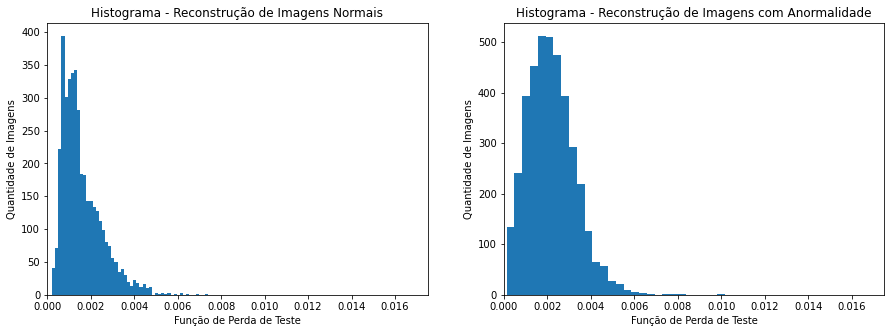

In [60]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 5))
axs[0].hist(losses_normal, bins = 50)
axs[0].set_title('Histograma - Reconstrução de Imagens Normais')
axs[0].set_xlabel('Função de Perda de Teste')
axs[0].set_ylabel('Quantidade de Imagens')
axs[0].set_xlim([0, 0.0175])

axs[1].hist(losses_abnormal, bins = 50)
axs[1].set_title('Histograma - Reconstrução de Imagens com Anormalidade')
axs[1].set_xlabel('Função de Perda de Teste')
axs[1].set_ylabel('Quantidade de Imagens')
axs[1].set_xlim([0, 0.0175])

### Qualidade da Reconstrução das Imagens com o Autoencoder

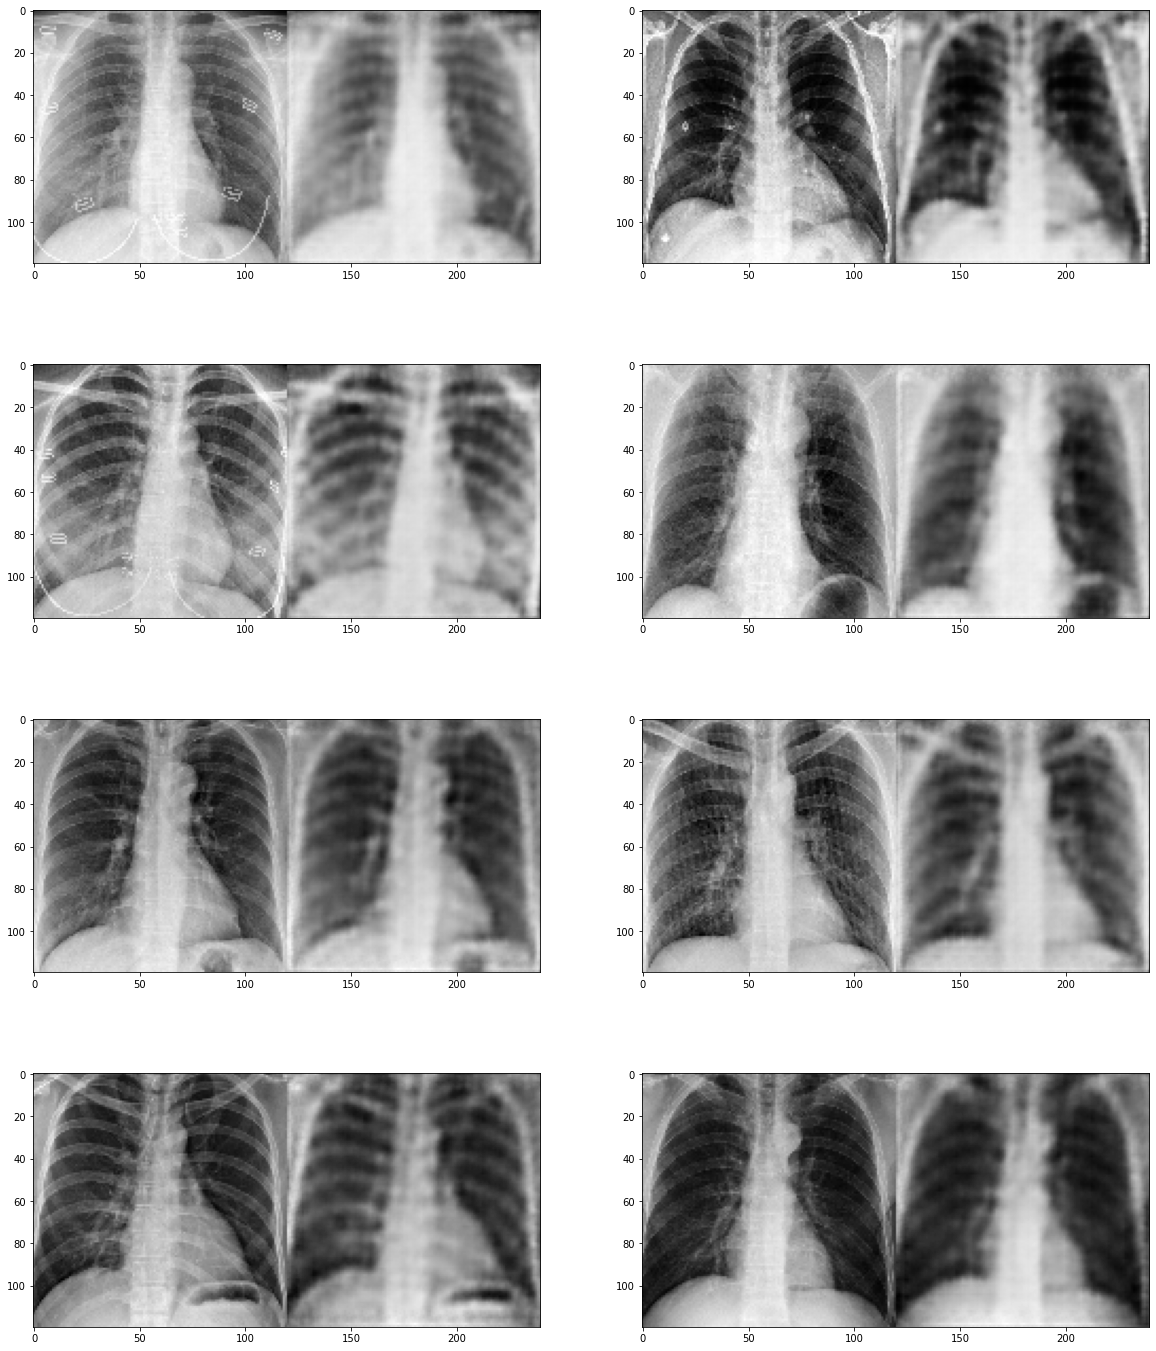

In [37]:
fig, axs = plt.subplots(nrows = 4, ncols = 2, figsize = (20, 25))

for i in range(0, 4):
  for j in range(0, 2):
    fig_index = random.randint(0, len(predict_normal))
    image1 = test_normal[fig_index][:,:,0]
    image2 = predict_normal[fig_index][:,:,0]
    axs[i,j].imshow(np.concatenate((image1, image2), axis = 1), cmap = 'gray')

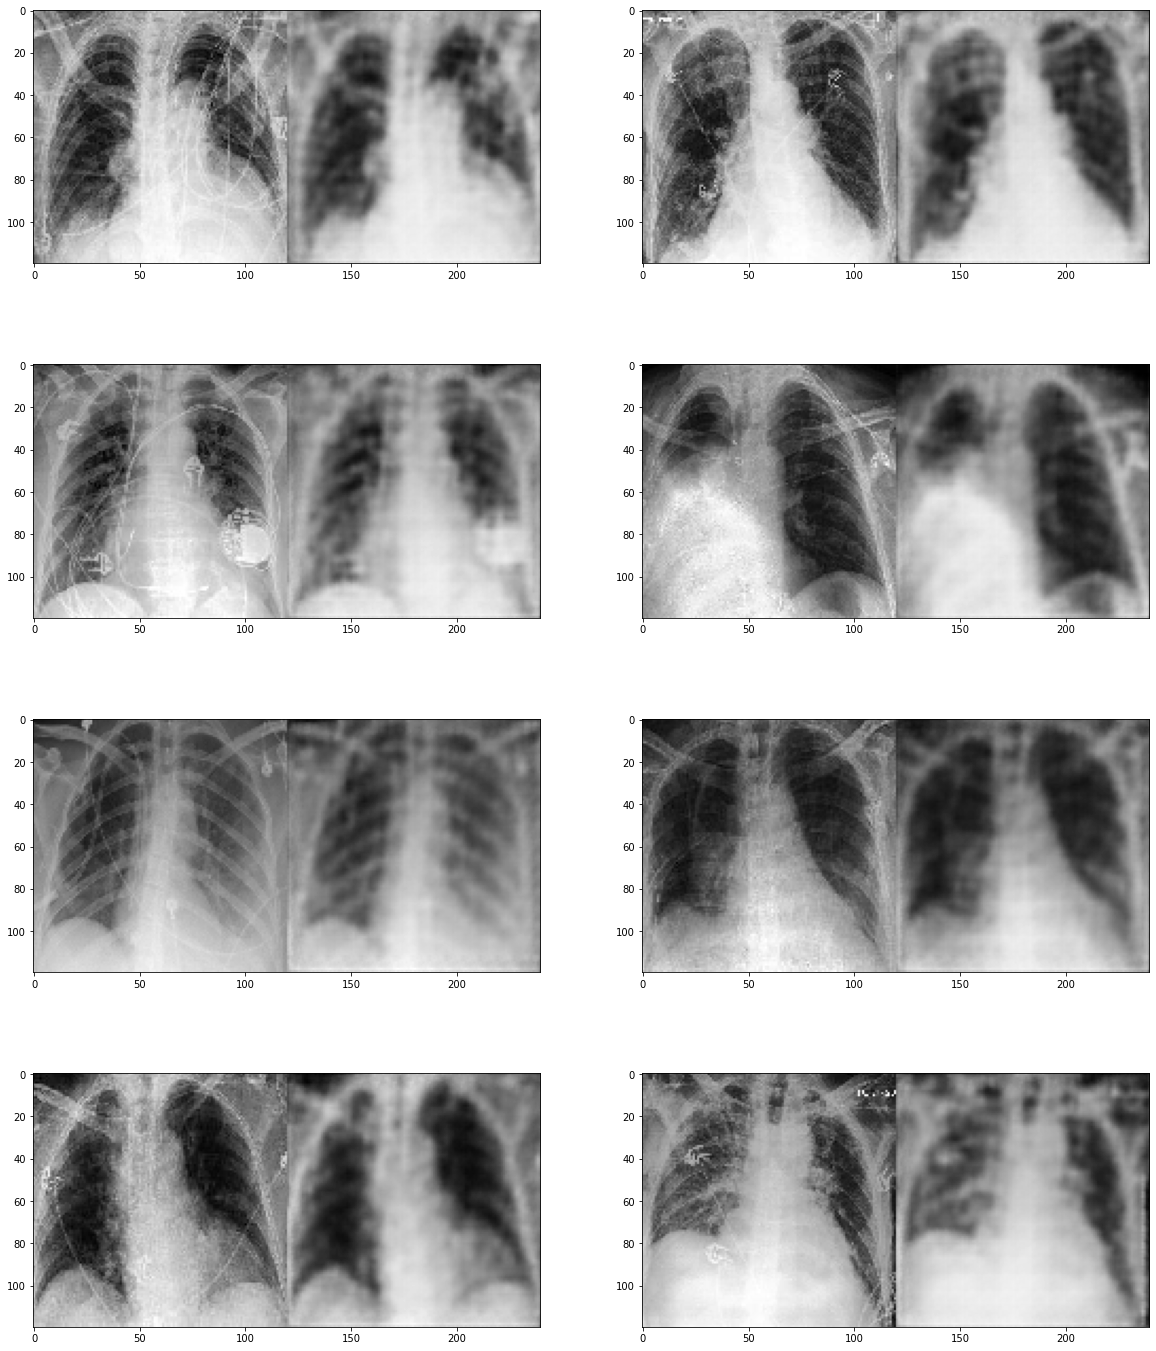

In [39]:
fig, axs = plt.subplots(nrows = 4, ncols = 2, figsize = (20, 25))

for i in range(0, 4):
  for j in range(0, 2):
    fig_index = random.randint(0, len(predict_abnormal))
    image1 = test_abnormal[fig_index][:,:,0]
    image2 = predict_abnormal[fig_index][:,:,0]
    axs[i,j].imshow(np.concatenate((image1, image2), axis = 1), cmap = 'gray')